# Dataset Features

Features

• id: Unique identifier assigned to each house sale.

• date: Sale date (the date the house was sold).

• price: Sale price of the house (target variable).

• bedrooms: Number of bedrooms in the house.

• bathrooms: Number of bathrooms in the house.

• sqft_living: Living area size of the house (in square feet).

• sqft_lot: Lot size (in square feet).

• floors: Number of floors in the house.

• waterfront: Whether the house is on the waterfront (1: house is on the waterfront, 0: house is not on the waterfront).

• view: Rating of the house's view (scale from 0 to 4).

• condition: Overall condition of the house (scale from 1 to 5).

• grade: Overall grade given to the housing unit, based on King County grading system (scale from 1 to 13).

• sqft_above: Size of the living area above ground (in square feet).

• sqft_basement: Size of the basement (in square feet).

• yr_built: Year the house was built.

• yr_renovated: Year the house was renovated.

• zipcode: ZIP code where the house is located.

• lat: Latitude coordinate of the house (geographic location).

• long: Longitude coordinate of the house (geographic location).

• sqft_living15: Average living area size of neighboring houses (in square feet).

• sqft_lot15: Average lot size of neighboring houses (in square feet).


# Lib & Dataset Import

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import shutil
import sys
import os
import math

import matplotlib.pyplot as plt
import statsmodels.api as sm
import plotly.graph_objs as go
import plotly.io as pio
import plotly.figure_factory as ff
from scipy.stats import uniform

from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("harlfoxem/housesalesprediction")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/housesalesprediction


# Prepare Data

In [ ]:
df = pd.read_csv(path + "/kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
# drop 'id' and 'zipcode' column
df.drop(['id', 'zipcode', 'date'], axis=1, inplace=True)

<ipython-input-5-8b84493038fa>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['price'])


<Axes: xlabel='price', ylabel='Density'>

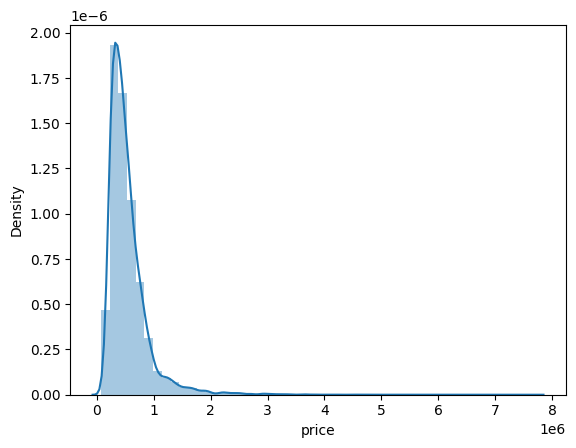

In [ ]:
# Chekcing Price Distributiong
sns.distplot(df['price'])

This figure shows that there is a skewness in the data (positive skew). indicating the presence of high-priced property that skewed the pricing distribution

In light of this, we decided to drop approximately 1% of the total entry on the dataset to try and normalize the distribution. Considering there are 21600 entry on the dataset, we will drop 216 property with the highest price

<ipython-input-6-2d49835d846e>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['price'])


<Axes: xlabel='price', ylabel='Density'>

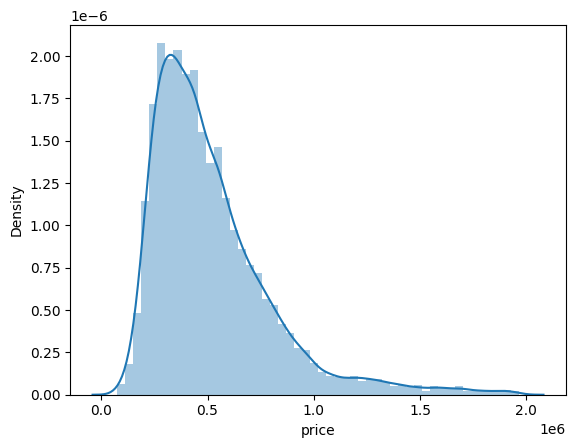

In [ ]:
df = df.sort_values(['price'], ascending=False).iloc[216:]
df.head()
sns.distplot(df['price'])

# Correlation Between Features

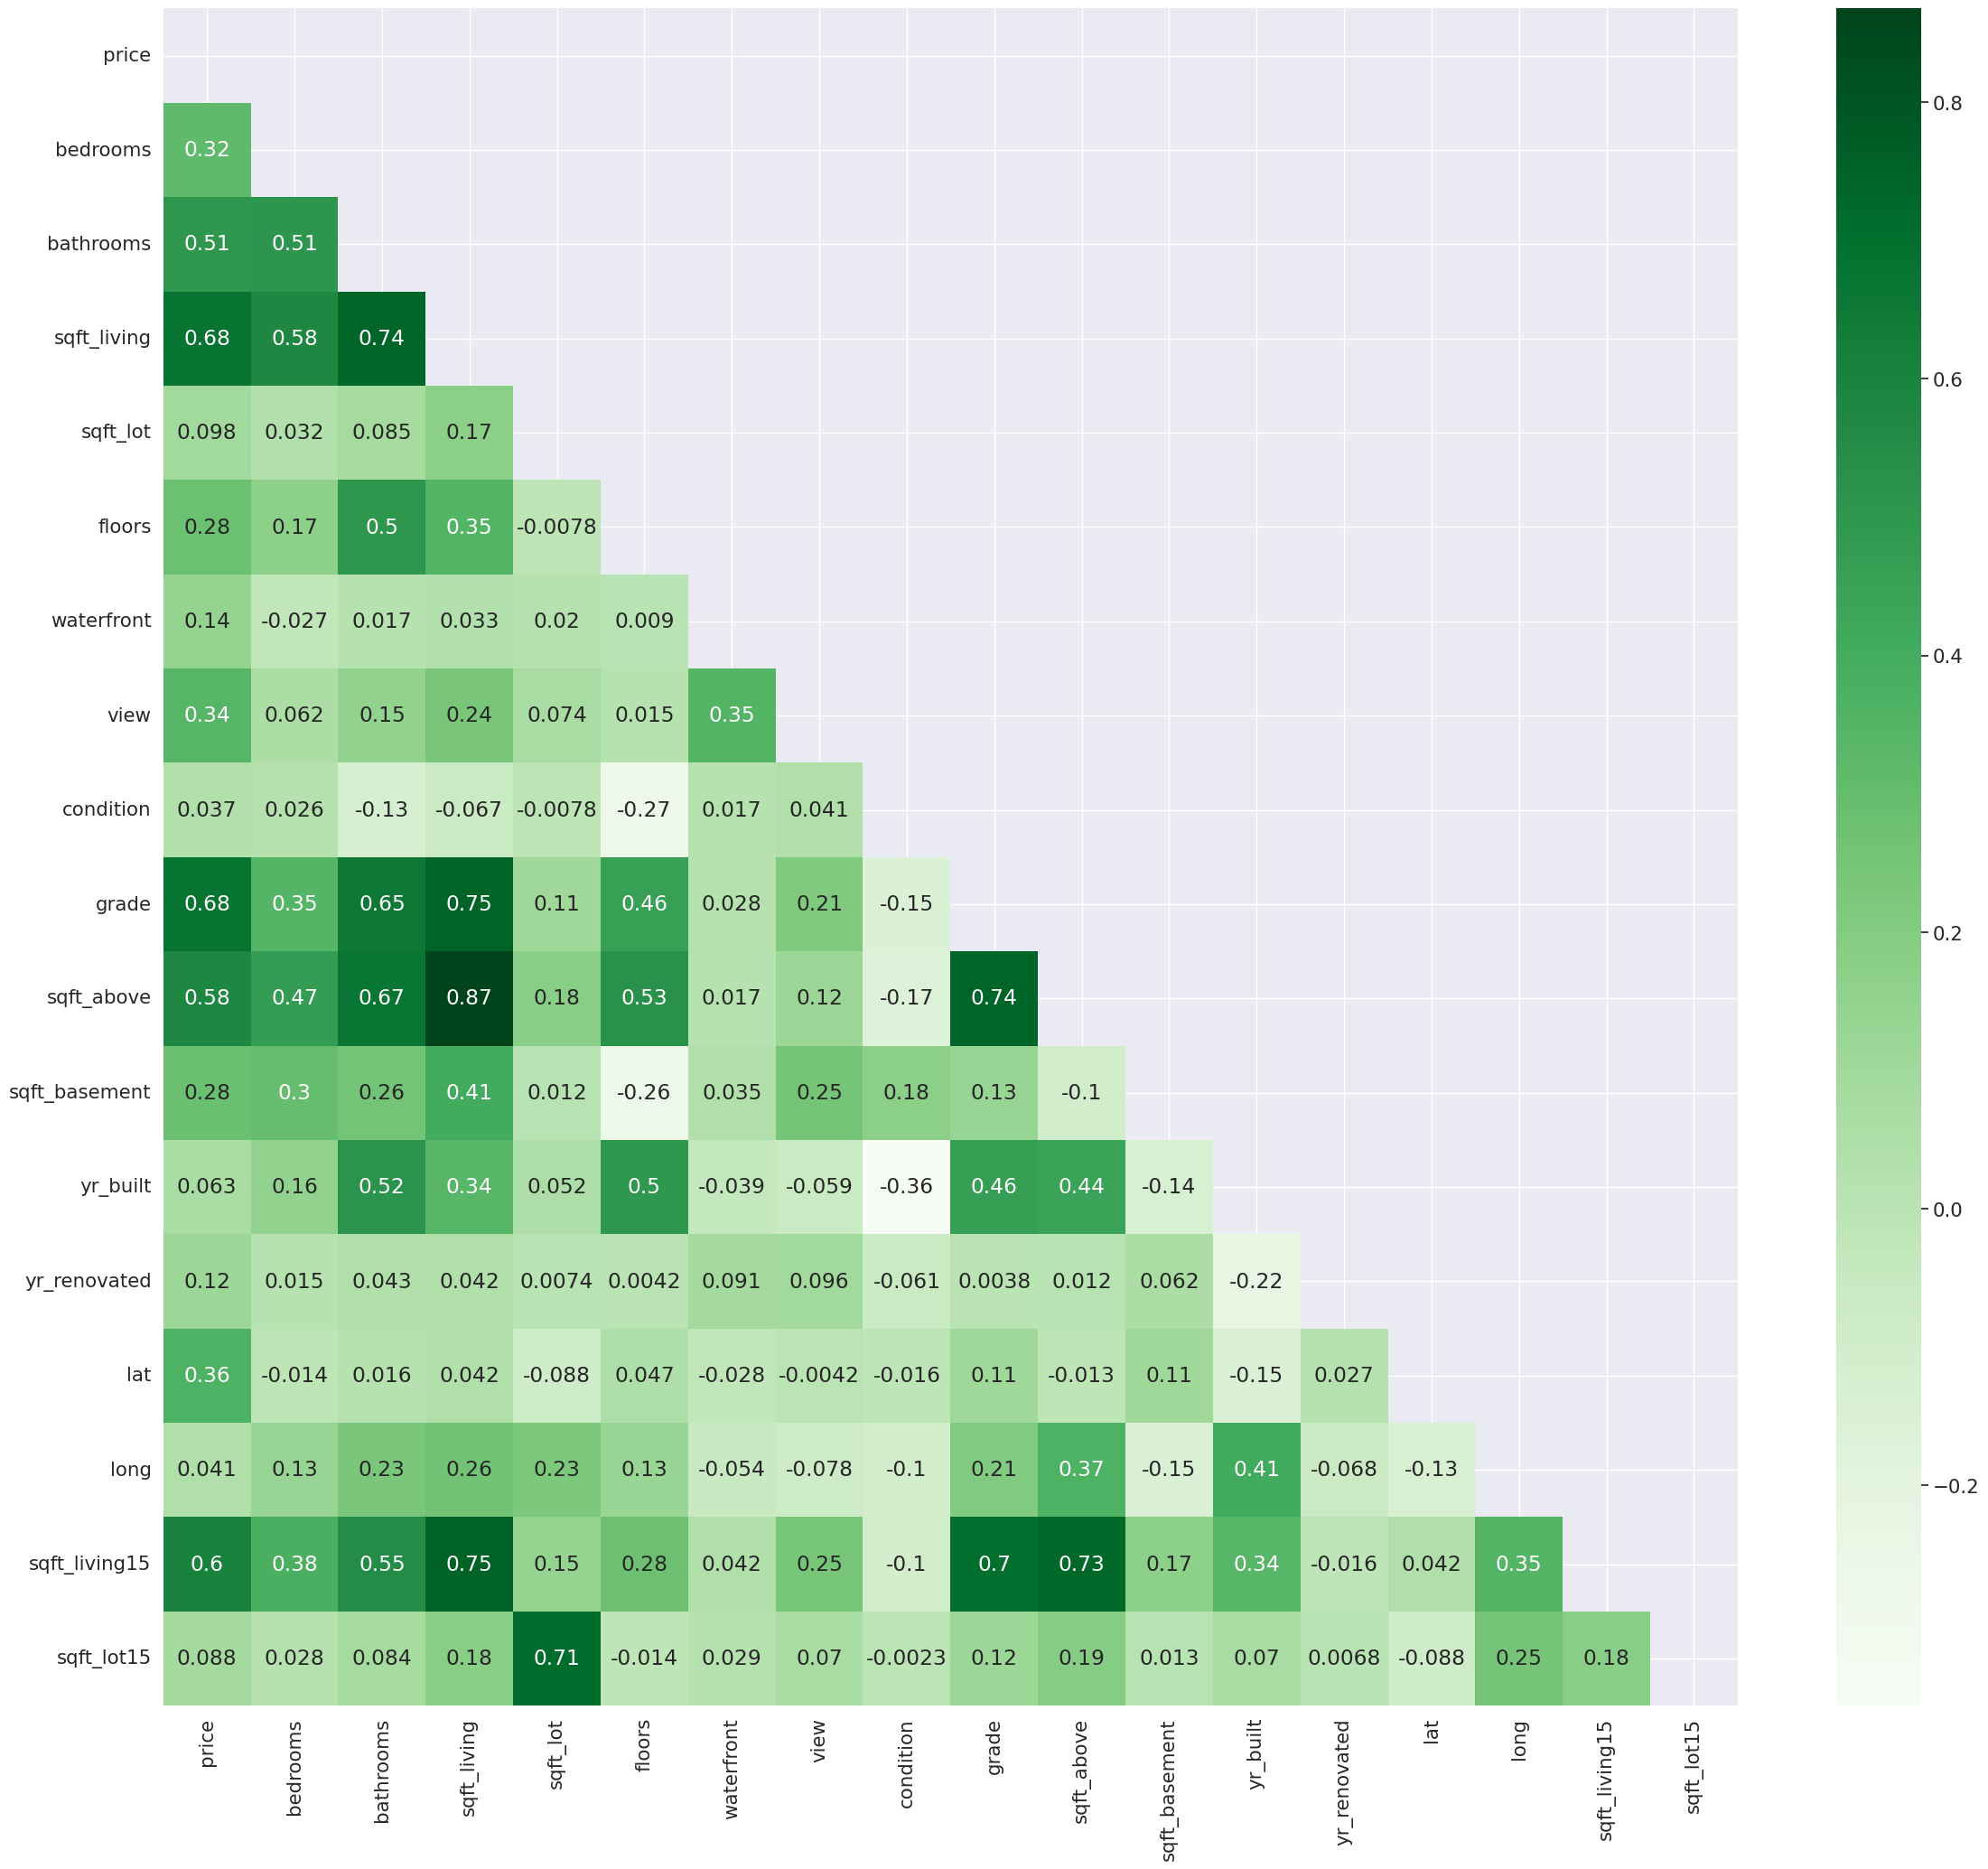

In [ ]:
cor = df.corr()
mask = np.triu(np.ones_like(cor, dtype=bool))
sns.set(font_scale=1.4)
plt.figure(figsize=(24,21))
sns.heatmap(cor, annot=True, mask=mask, cmap='Greens')
plt.tight_layout()
plt.show()

# Building Model

Running RandomizedSearch to find the best hyperparameter for the SVR model

In [ ]:
param_dist = {
    'C': uniform(1, 100),
    'epsilon': uniform(0.01, 0.5),
    'gamma': ['scale', 0.01, 0.1, 1]
}

random_search = RandomizedSearchCV(
    SVR(kernel='rbf'),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_squared_error'
)
random_search.fit(X_train_scaled, Y_train_scaled.ravel())


Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=SVR(), n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f2322b2d5d0>,
                                        'epsilon': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f23234a2510>,
                                        'gamma': ['scale', 0.01, 0.1, 1]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

## Using DataScaler for SVM Model

In [ ]:
selected_features = [
   'price',
   'bedrooms',
   'bathrooms',
   'sqft_living',
   'sqft_lot',
   'floors',
   'waterfront',
   'view',
   'condition',
   'grade',
   'sqft_above',
   'sqft_basement',
   'yr_built',
   'yr_renovated'
]

In [ ]:
df.head(1)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
3281,1965000.0,5,3.75,3940,13738,1.5,0,3,4,9,3940,0,1951,0,47.6203,-122.212,2370,13320


In [ ]:
# Creating X and Y (features and labels)
x = df.iloc[:,1:]
X = x.values
y = df.iloc[:,0:1]
#X = df[selected_features].values
Y = y.values

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Feature scaling
sc_X = StandardScaler()
X_train_scaled = sc_X.fit_transform(X_train)
X_test_scaled = sc_X.transform(X_test)

sc_Y = StandardScaler()
Y_train_scaled = sc_Y.fit_transform(Y_train)
Y_test_scaled = sc_Y.transform(Y_test)

# Flatten the Y arrays
Y_train_scaled = np.ravel(Y_train_scaled)
Y_test_scaled = np.ravel(Y_test_scaled)

# Train the SVR model
svr_reg = SVR(
    kernel='rbf',
    C=78.96910002727692,
    epsilon=0.3084250789732435,
    gamma=0.01
)
svr_reg.fit(X_train_scaled, Y_train_scaled)

# Predict on test data
y_pred_scaled = svr_reg.predict(X_test_scaled)

# Inverse transform predictions and actuals
y_pred = sc_Y.inverse_transform(y_pred_scaled.reshape(-1,1))
Y_test_orig = sc_Y.inverse_transform(Y_test_scaled.reshape(-1,1))

# Evaluate the model
print("R² Score on Test Set :", r2_score(Y_test_orig, y_pred) * 100)
print("MAE:", mean_absolute_error(Y_test_orig, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(Y_test_orig, y_pred)))


R² Score on Test Set : 82.97449129680821
MAE: 77723.58439054416
RMSE: 114637.46365142778


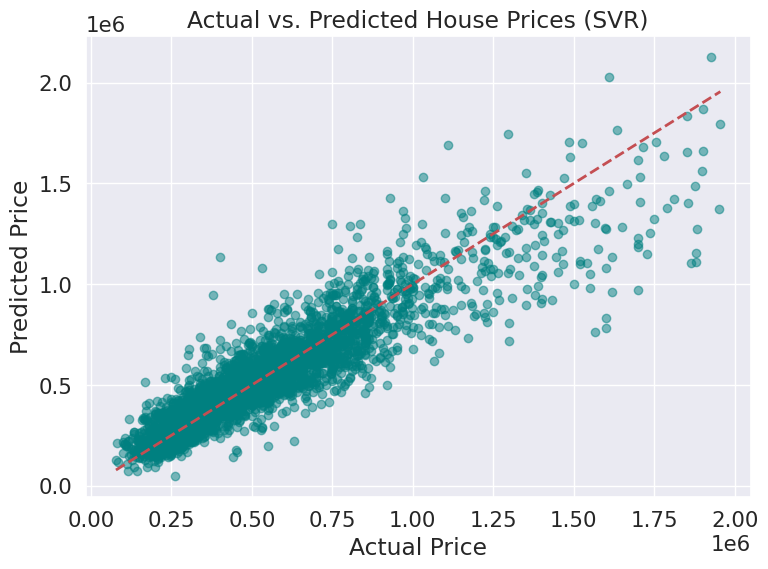

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(Y_test_orig, y_pred, alpha=0.5, color='teal')
plt.plot([Y_test_orig.min(), Y_test_orig.max()], [Y_test_orig.min(), Y_test_orig.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted House Prices (SVR)')
plt.grid(True)
plt.tight_layout()
plt.show()


# Inference

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Estimation
def test_estimation(input_features, actual_price, X_train_scaled, Y_train_scaled, sc_Y, svr_model):
    # Convert and scale input
    single_input = np.array([input_features])
    single_input_scaled = sc_X.transform(single_input)

    # Predict on neighbors to simulate uncertainty
    from sklearn.metrics.pairwise import euclidean_distances
    distances = euclidean_distances(X_train_scaled, single_input_scaled)
    k = 25
    idx_nearest = np.argsort(distances[:, 0])[:k]
    local_preds_scaled = svr_model.predict(X_train_scaled[idx_nearest])
    local_preds = sc_Y.inverse_transform(local_preds_scaled.reshape(-1, 1))

    # Aggregate statistics
    estimated_price = np.mean(local_preds)
    lower_bound = np.percentile(local_preds, 5)
    upper_bound = np.percentile(local_preds, 95)

    print(f"Estimated Price: ${estimated_price:,.2f}")
    print(f"95% Confidence Interval: ${lower_bound:,.2f} - ${upper_bound:,.2f}")
    print(f"Actual Price: ${actual_price:,.2f}")
    print(f"Estimation Error: ${abs(estimated_price - actual_price):,.2f}")


In [ ]:
input_features = [3, 2, 1800, 5000, 1, 0, 0, 3, 7, 1200, 600, 1995, 0, 47.6, -122.3, 1850, 5100]
actual_price = 500000

test_estimation(input_features, actual_price, X_train_scaled, Y_train_scaled, sc_Y, svr_reg)


Estimated Price: $426,535.77
95% Confidence Interval: $355,372.70 - $492,949.35
Actual Price: $500,000.00
Estimation Error: $73,464.23


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
def test_model(input_features, actual_price):
    input = np.array([input_features])

    # Scale the input data using the same scaler
    input_scaled = sc_X.transform(input)

    # Predict using the trained SVR model
    input_pred_scaled = svr_reg.predict(input_scaled)

    # Inverse transform the scaled prediction back to the original scale (price scale)
    input_pred = sc_Y.inverse_transform(input_pred_scaled.reshape(-1, 1))

    # Calculate and print the prediction vs. actual price
    predicted_price = input_pred[0][0]

    print(f"Estimated Price for the house: ${predicted_price:,.2f}")
    print(f"Actual Price for the house: ${actual_price:,.2f}")

    error = abs(predicted_price - actual_price)
    print(f"Estimation Error: ${error:,.2f}")

In [ ]:
import joblib

#Save trained model & scalers
joblib.dump(svr_reg, 'svr_model.pkl')
joblib.dump(sc_X, 'scaler_X.pkl')
joblib.dump(sc_Y, 'scaler_Y.pkl')
joblib.dump(X_train_scaled, "X_train_scaled.pkl")
joblib.dump(Y_train_scaled, "Y_train_scaled.pkl")


['scaler_Y.pkl']

Test Data

In [ ]:
# Priced around 300k
low_end = [
    [2, 1.0, 900, 3000, 1.0, 0, 0, 3, 5, 900, 0, 1955, 0, 47.51, -122.34, 1000, 3500],
    [2, 1.0, 1100, 4000, 1.0, 0, 0, 3, 6, 1100, 0, 1968, 0, 47.52, -122.33, 1150, 4100],
    [3, 1.5, 1200, 3200, 1.0, 0, 0, 3, 6, 1000, 200, 1970, 0, 47.50, -122.36, 1300, 3400],
    [2, 1.0, 980, 3500, 1.0, 0, 0, 3, 5, 980, 0, 1950, 0, 47.49, -122.35, 990, 3700],
    [3, 1.0, 1050, 2800, 1.0, 0, 0, 3, 6, 900, 150, 1965, 0, 47.53, -122.31, 1100, 2900],
]

# Priced around 500k
mid_range = [
    [3, 2.0, 1800, 5000, 1.0, 0, 0, 3, 7, 1400, 400, 1995, 0, 47.53, -122.30, 1850, 5100],
    [4, 2.5, 2200, 6200, 2.0, 0, 1, 3, 7, 1600, 600, 2001, 0, 47.54, -122.28, 2100, 6000],
    [3, 2.0, 1700, 4800, 1.0, 0, 0, 3, 7, 1300, 400, 1992, 0, 47.52, -122.31, 1750, 4900],
    [4, 2.0, 2000, 5500, 1.0, 0, 1, 3, 8, 1500, 500, 1985, 0, 47.55, -122.29, 1950, 5800],
    [3, 2.0, 1600, 4500, 1.0, 0, 0, 3, 7, 1300, 300, 1990, 0, 47.51, -122.33, 1650, 4700],
]

# Priced around 700k
high_end = [
    [5, 4.0, 4000, 12000, 2.0, 0, 3, 4, 11, 3000, 1000, 2010, 0, 47.56, -122.27, 3900, 12500],
    [4, 3.5, 3500, 10000, 2.0, 1, 4, 4, 10, 2700, 800, 2005, 0, 47.58, -122.25, 3600, 10200],
    [6, 5.0, 4800, 14000, 2.0, 0, 2, 4, 12, 3500, 1300, 2018, 0, 47.57, -122.26, 4700, 14500],
    [4, 3.0, 3200, 9500, 2.0, 1, 3, 4, 10, 2400, 800, 2012, 0, 47.59, -122.24, 3300, 9600],
    [5, 4.0, 4100, 13000, 2.0, 0, 3, 4, 11, 3100, 1000, 2008, 0, 47.60, -122.23, 4200, 13200],
]


In [ ]:
[bedrooms, bathrooms, sqft_living, sqft_lot, floors,
 waterfront, view, condition, grade,
 sqft_above, sqft_basement, yr_built, yr_renovated,
 lat, long, sqft_living15, sqft_lot15]